In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets
y_corrected = []

for i in y["income"]:
  if '<' in i:
    y_corrected.append(0)
  else:
    y_corrected.append(1)

y = pd.DataFrame()
y["income"] = y_corrected

# variable information
print(adult.variables)


              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

# X_encoded = pd.get_dummies(X, drop_first=True)

# Identifying categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Creating a ColumnTransformer to apply OneHotEncoding to the categorical columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                   categorical_columns)])

# Applying the preprocessor to our features X
X_processed = preprocessor.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
gradient_booster = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Fit the model
gradient_booster.fit(X_train, y_train)

# Predict on the test set
y_pred = gradient_booster.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the Gradient Boosting classifier on test set: {:.2f}%'.format(accuracy * 100))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the Gradient Boosting classifier on test set: 83.03%


In [ ]:
from sklearn.model_selection import GridSearchCV

# Reduce the training set to the first 10,000 data points to speed up the hyperparameter tuning
X_train_reduced = X_train[:10000]
y_train_reduced = y_train[:10000]

# Define a range of hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [1, 3, 5]
}

# Initialize the Gradient Boosting Classifier
gradient_booster2 = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(gradient_booster2, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_reduced, y_train_reduced)

# Best parameters
best_params = grid_search.best_params_
print('Best parameters found on reduced set: ', best_params)

# Best score
best_score = grid_search.best_score_
print('Best cross-validated accuracy on reduced set: {:.2f}%'.format(best_score * 100))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found on reduced set:  {'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 100}
Best cross-validated accuracy on reduced set: 58.01%


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import sklearn.tree as tree
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

adult_df = X.copy(deep=True)
adult_df["income"] = y

# Get rid of the entries where the occupation or workclass is unknown
adult_df = adult_df[adult_df['occupation'] != '?']
adult_df = adult_df[adult_df['workclass'] != '?']
adult_df = adult_df[adult_df['native-country'] != '?']

# Get the dummies for the columns
categorical_columns = adult_df.select_dtypes(include=['object']).columns
adult_df = pd.get_dummies(data = adult_df, columns = categorical_columns)

y = pd.DataFrame()
y = adult_df["income"]
adult_df.drop("income", axis=1, inplace=True)

# make df into numpy
X_proc = adult_df.to_numpy()

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)

# Initialize the Optimized AdaBoosting Classifier
ada_booster = AdaBoostClassifier(random_state=42)
ada_booster.fit(X_train, y_train)


# Predict on the test set
y_pred = ada_booster.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the AdaBoosting classifier with default parameters ' +
       'on test set: {:.2f}%'.format(accuracy * 100))



Accuracy of the AdaBoosting classifier with default parameters on test set: 86.12%


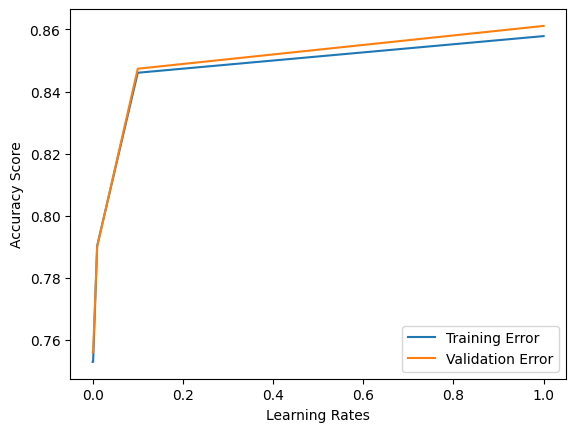

In [ ]:
X_train_red = X_train[:20000, :]
y_train_red = y_train[:20000]

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

tr_err = []
val_err = []

for lr in learning_rates:
  ab = AdaBoostClassifier(random_state=42, learning_rate=lr).fit(X_train_red, y_train_red)
  tr_err.append(ab.score(X_train_red, y_train_red))
  val_err.append(ab.score(X_test, y_test))

plt.plot(learning_rates, tr_err, label="Training Error")
plt.plot(learning_rates, val_err, label="Validation Error")
plt.xlabel('Learning Rates')
plt.ylabel('Accuracy Score')
plt.legend()

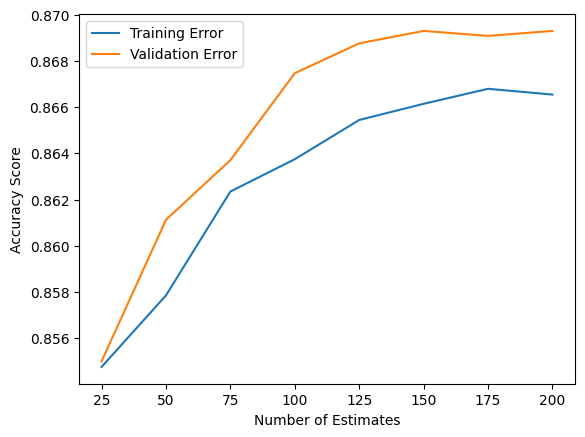

In [ ]:
num_est = [25, 50, 75, 100, 125, 150, 175, 200]

tr_err = []
val_err = []

for es in num_est:
  ab = AdaBoostClassifier(random_state=42, learning_rate=1, n_estimators=es).fit(X_train_red, y_train_red)
  tr_err.append(ab.score(X_train_red, y_train_red))
  val_err.append(ab.score(X_test, y_test))

plt.plot(num_est, tr_err, label="Training Error")
plt.plot(num_est, val_err, label="Validation Error")
plt.xlabel('Number of Estimates')
plt.ylabel('Accuracy Score')
plt.legend()

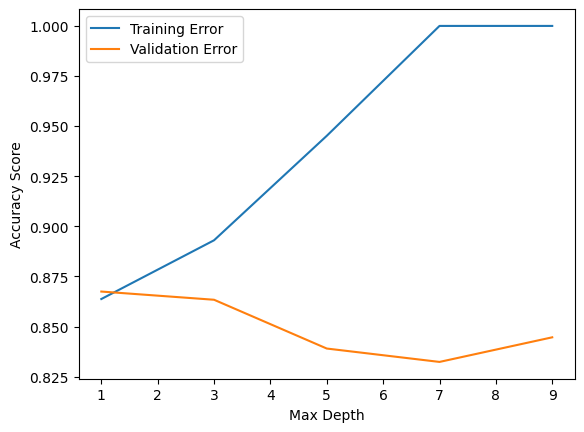

In [ ]:
max_depths = [1, 3, 5, 7, 9]

tr_err = []
val_err = []

for d in max_depths:
  ab = AdaBoostClassifier(random_state=42, learning_rate=1, n_estimators=100,
                          estimator=tree.DecisionTreeClassifier(max_depth=d)).fit(X_train_red, y_train_red)
  tr_err.append(ab.score(X_train_red, y_train_red))
  val_err.append(ab.score(X_test, y_test))

plt.plot(max_depths, tr_err, label="Training Error")
plt.plot(max_depths, val_err, label="Validation Error")
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()

In [ ]:
lr = [0.01, 0.1, 1]
est = [50, 100, 150, 200, 250]

for l in lr:
  for e in est:
    ab = ada_booster = AdaBoostClassifier(random_state=42, learning_rate=l, n_estimators=e)
    ab.fit(X_train_red, y_train_red)
    y_pred = ab.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"learning rate: {l}\nestimator: {e}\naccuracy: {accuracy}\n\n")



learning rate: 0.01
estimator: 50
accuracy: 0.7900742814081171


learning rate: 0.01
estimator: 100
accuracy: 0.7900742814081171


learning rate: 0.01
estimator: 150
accuracy: 0.7899666271934547


learning rate: 0.01
estimator: 200
accuracy: 0.8150500592098181


learning rate: 0.01
estimator: 250
accuracy: 0.8214016578749058


learning rate: 0.1
estimator: 50
accuracy: 0.8473463236085693


learning rate: 0.1
estimator: 100
accuracy: 0.854128539132307


learning rate: 0.1
estimator: 150
accuracy: 0.8542361933469695


learning rate: 0.1
estimator: 200
accuracy: 0.8556356981375821


learning rate: 0.1
estimator: 250
accuracy: 0.8569275487135322


learning rate: 1
estimator: 50
accuracy: 0.8611260630853698


learning rate: 1
estimator: 100
accuracy: 0.8674776617504575


learning rate: 1
estimator: 150
accuracy: 0.8693077833997201


learning rate: 1
estimator: 200
accuracy: 0.8693077833997201


learning rate: 1
estimator: 250
accuracy: 0.8705996339756702




In [ ]:
# Initialize the Optimized AdaBoosting Classifier
ada_booster = AdaBoostClassifier(random_state=42, n_estimators=150)
ada_booster.fit(X_train, y_train)


# Predict on the test set
y_pred = ada_booster.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the AdaBoosting classifier with default parameters' +
       'on test set: {:.2f}%'.format(accuracy * 100))


Accuracy of the AdaBoosting classifier with default parameterson test set: 86.91%
